# Танцующие человечки и MCMC

(Взято из http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%BC%D0%BC%D0%BE)

В рассказе The Adventure of the Dancing Men великий сыщик Шерлок Холмс расшифровал загадочные письмена, которые выглядели примерно так:

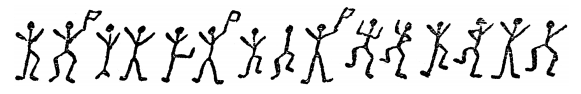

In [1]:
from IPython.display import Image
Image("dancing_men.png")

Пользовался он для этого так называемым частотным методом: смотрел, какие буквы чаще встречаются в зашифрованных текстах, и пытался подставить буквы в соответствии с частотной таблицей: E &mdash; самая частая и так далее.

Здесь мы разработаем и реализуем более современный и продвинутый вариант такого частотного метода, основанный на MCMC-семплировании. 

In [2]:
import numpy as np
import re
from collections import Counter

In [3]:
alphabet = ''.join([chr(ord('а') + i) for i in range(32)]) + ' '  # russian alphabet w/o 'ё' + whitespace
all_unigrams = list(alphabet)
all_bigrams = [a + b for a in alphabet for b in alphabet]

In [5]:
alphabet

'абвгдежзийклмнопрстуфхцчшщъыьэюя '

In [6]:
def prepare_text(text):
    """
        text: a string

        return: modified string
    """
    text = text.lower().strip()  # lowercase and trim
    text = re.sub(r"[,.;@#?!&$]+\ *", ' ', text)  # punctuation to whitespace
    text = re.sub('[^а-яё ]+', '', text)  # remove other "bad" symbols
    text = text.replace('ё', 'е')
    text = ' '.join(word for word in text.split())  # final words concatenation
    return text

def text2ngrams(text, n=1):
    """
        text: a string
        
        return: list of n-grams
    """
    return [text[i:i+n] for i in range(len(text)-n+1)]

В качестве корпуса текста для подсчётов частот возьмем “Войну и мир”.

Нам понадобятся как униграммы (частоты отдельных символов), так и биграммы (частоты пар символов).

In [8]:
# Initialize with all n-grams to avoid zero freqs
unigram_cntr = Counter(all_unigrams)
bigram_cntr = Counter(all_bigrams)

with open("WarAndPeace.txt", encoding='utf') as f:
    for text in f.readlines():
        text = prepare_text(text)
        unigram_cntr.update(text2ngrams(text, 1))
        bigram_cntr.update(text2ngrams(text, 2))
        
freq_sort = lambda cntr: [pair[0] for pair in sorted(cntr.items(), key=lambda item: item[1], reverse=True)]
unigram_sorted = freq_sort(unigram_cntr)
bigram_sorted = freq_sort(bigram_cntr)

Для удобства и простоты будем шифровать русские буквы русскими же буквами методом сдвига, а именно, циклически "сдвинем" алфавит и соответственно перекодируем буквы в исходном тексте.

In [9]:
shift = 5
shifted_alphabet = alphabet[shift:] + alphabet[:shift]
print("Source alphabet:\t", alphabet)
print("Shifted alphabet:\t", shifted_alphabet)

Source alphabet:	 абвгдежзийклмнопрстуфхцчшщъыьэюя 
Shifted alphabet:	 ежзийклмнопрстуфхцчшщъыьэюя абвгд


In [10]:
enc_table = str.maketrans(alphabet, shifted_alphabet)
encrypt_text = lambda text, table=enc_table: text.translate(table)

# Testing
text = "Быть или не быть, вот в чем вопрос..."
text = prepare_text(text)
print("Source text:\t", text)
print("Encrypted text:\t", encrypt_text(text))

Source text:	 быть или не быть вот в чем вопрос
Encrypted text:	 ж чаднрндткдж чадзучдздьксдзуфхуц


Для (де-)шифровки возьмем финальную речь цирюльника в образе Аденоида Хинкеля из фильма Великий диктатор.

In [11]:
with open("GreatDictator.txt", encoding='utf') as f:
    test_text = ' '.join(f.readlines())

test_text = prepare_text(test_text)

print("Test text:")
print(test_text)

Test text:
к сожалению я не могу стать императором это не моя профессия я не хочу властвовать и завоевывать я хотел бы по возможности помочь всем евреям христианам черным белым все мы хотим помогать друг другу мы так устроены хотим жить счастьем других не их страданиями мы не хотим ни ненавидеть ни презирать есть место для каждого земля богата и может накормить всех жизнь может быть свободной и прекрасной но мы сбились с пути алчность отравила души людей воздвигла барьеры ненависти привела нас к страданиям и кровопролитию мы набрали скорость но замкнулись в себе машины дают изобилие оставляя в нужде знания делают нас циничными а мастерство жесткими мы много думаем и мало чувствуем нам нужны не машины а человечность нам недостает мастерства но еще больше доброты без них в жизни властвует жестокость и подавляется воля самолеты и радио сблизили нас сама природа этих изобретений взывает к доброте к братству и сплоченности мой голос доходит в этот момент до миллионов отчаявшихся мужчин женщ

In [12]:
test_enc_text = test_text.translate(enc_table)
print("Test text encrypted:")
print(test_enc_text)

Test text encrypted:
пдцулерктнвдгдткдсуишдцчечаднсфкхечухусдбчудткдсугдфхущкццнгдгдткдъуьшдзрецчзузечадндмезукз зечадгдъучкрдж дфудзумсултуцчндфусуьадзцксдкзхкгсдъхнцчнетесдькхт сджкр сдзцкдс дъучнсдфусуиечадйхшидйхшишдс дчепдшцчхукт дъучнсдлнчадцьецчаксдйхшинъдткднъдцчхейетнгсндс дткдъучнсдтндтктезнйкчадтндфхкмнхечадкцчадскцчудйргдпелйуиудмксргджуиечедндсулкчдтепухснчадзцкъдлнмтадсулкчдж чадцзужуйтуодндфхкпхецтуодтудс дцжнрнцадцдфшчндерьтуцчадучхезнредйшэндрвйкодзумйзниреджехакх дтктезнцчндфхнзкредтецдпдцчхейетнгсдндпхузуфхурнчнвдс дтежхерндцпухуцчадтудмесптшрнцадздцкжкдсеэнт дйевчднмужнрнкдуцчезрггдздтшлйкдмтетнгдйкревчдтецдынтньт сндедсецчкхцчзудлкцчпнсндс дстуиудйшсексдндсерудьшзцчзшксдтесдтшлт дткдсеэнт дедькрузкьтуцчадтесдткйуцчекчдсецчкхцчзедтудкюкджураэкдйужхуч джкмдтнъдздлнмтндзрецчзшкчдлкцчупуцчадндфуйезргкчцгдзургдцесуркч дндхейнудцжрнмнрндтецдцеседфхнхуйедбчнъднмужхкчктнодзм зекчдпдйужхучкдпджхечцчзшдндцфруькттуцчндсуодиуруцдйуъуйнчдздбчучдсусктчдйудснррнутуздучьегзэнъцгдс

## Частотный подход

Итак, тут все просто: отранжируем n-граммы по частоте в зашифрованном тексте (Великий диктатор) и сопоставим с соответствующими n-граммами из большого исходного текста (Война и мир).

#### Униграммы

In [13]:
test_unigram_cntr = Counter(all_unigrams)
test_unigram_cntr.update(text2ngrams(test_enc_text, 1))
test_unigram_sorted = freq_sort(test_unigram_cntr)

test_dec_text = "".join([unigram_sorted[test_unigram_sorted.index(c)] for c in test_enc_text])
print("Decryted test text:")
print(test_dec_text)
print(100 * '-')
print("Error rate: ", sum(c1 != c2 for c1, c2 in zip(test_text, test_dec_text)) / len(test_text))

Decryted test text:
ь точидасех у са вожп тнинм евзариноров эно са воу зроъаттеу у са йоып лдитнлолинм е билоалглинм у йонад яг зо лобвочсотне зовоым лтав алраув йретнеисив ыарсгв яадгв лта вг йонев зовожинм крпж крпжп вг ниь птнроасг йонев ченм тыитнмав крпжей са ей тнрикисеуве вг са йонев се сасилеканм се зраберинм атнм ватно кду ьичкожо бавду яожини е вочан сиьорвенм лтай чебсм вочан ягнм тлояоксош е зраьритсош со вг тяедетм т зпне идысотнм онриледи кпце дхкаш лобклежди яирмарг сасилетне зрелади сит ь тнрикисеув е ьролозроденех вг сияриде тьоротнм со бивьспдетм л таяа вицесг кихн ебояедеа отнилдуу л спчка бсисеу кадихн сит щесеысгве и витнартнло чатньеве вг всожо кпвиав е видо ыплтнлпав сив спчсг са вицесг и ыадолаысотнм сив сакотниан витнартнли со аюа яодмца кояронг яаб сей л чебсе лдитнлпан чатноьотнм е зокилдуанту лоду тиводанг е рикео тядебеде сит тиви зрероки эней ебояранасеш лбглиан ь коярона ь яринтнлп е тздоыассотне вош жодот койокен л энон вовасн ко веддеосол оныиулцейту вп

#### Биграммы

In [14]:
test_bigram_cntr = Counter(all_bigrams)
test_bigram_cntr.update(text2ngrams(test_enc_text, 2))
test_bigram_sorted = freq_sort(test_bigram_cntr)

test_dec_text = []
for i in range(len(test_enc_text) // 2):
    bi = test_enc_text[2*i:2*(i+1)]
    idx = test_bigram_sorted.index(bi)
    test_dec_text.append(bigram_sorted[idx])
test_dec_text = "".join(test_dec_text)

print("Decryted test text:")
print(test_dec_text)
print(100 * '-')
print("Error rate: ", sum(c1 != c2 for c1, c2 in zip(test_text, test_dec_text)) / len(test_text))

Decryted test text:
месебрбу иботоя  нх  че м  ву вукоенол княноя  ншкь ольмсвавгло  скньна ате л лостпотьк мнивлостглимй веоснариа иереялни бь ляз  вльзадучуца кссда б рде еорн  кинув кль стиимй у ь лях м  вкуеб ослош ннаазмейниймнн имй у миже вспрастза ослепиля поиле коел идни тио  скн б к ио рок яс д в иь  зажкостдуе  в эе нокитобедрх новзшлтолаязазпо нвс до чаваскста анилмади вреаянеияст пл лаужегпоь  зедрака тка ннаезпеда воггу бшебакае  вй ко мат опии удот тл р  мвлго шжиорная ал ме и актявегоалогмее коел иднпоодолл акбыжеьс ннааладвии цеванисто ноы чнутт с а  печ счтдон  осьненыерпе уоне к еттолиутдр сди рав овесьнеалогби ичегри гочте оре л миовблу и ти нкару озвож ки чтой еряе тызао део ехн о  счтдон ше евев обкае  вал кя асе ожнечте оре лоо ноул слачинь оеролихосзно  аа мины иа ате ты дмиовенлее  ви риелемщид тол ет пдебы днаи коесноезт ажт о ра пдегоаксяпргоня апоозад дроуза афло дод оеролвоодоскод  г чи айойтетсни б негамбыни ордпржеа итеннере эющ оноскврщекалий хойсдошнтоги

Как видим, такой наивный подход не смог правильно распознать и половины символов в исходном зашифрованном тексте.

## MCMC подход

Попробуем подойти к данной задаче с другой стороны.

Рассмотрим пространство всевозможных ключей шифрования $X$.
Каждый ключ $x \in X$ &mdash; это перестановка исходного алфавита.
Ясно, что, раз мы зашифровали исходное сообщение с помощью некоторого ключа $x_e \in X$ (как-то перемешали буквы в нашем алфавите), то обязательно найдется обратный ключ $x_d = (x_e)^{-1} \in X$, с помощью которого сообщение можно дешифровать (переставить буквы в обратном порядке).
Вообще говоря, для 33-буквенного алфавита $|X| = 33!$, а это достаточно много, поэтому простым перебором эту задачу решить не получится.

Введем следующую вероятностную модель.
Пусть $c(a, b)$ обозначает количество раз, которое пара символов $ab$ встретилась вместе в большом исходном тексте (Война и мир).
Пусть далее $f_x(a, b)$ обозначает количество раз, которое пара символов $ab$ встретилась вместе в тексте, полученным из зашифрованного (Великий диктатор) после дешифровки с ключом $x \in X$.
Правдоподобие ключа $x$ введем как
$$\pi(x) \propto \prod_{a, b} c(a, b)^{f_x(a, b)}.$$
Логика за этим стоит следующая: мы ожидаем, что при удачной дешифровке "эмпирические" частоты $f_x(a, b)$ должны (приблизительно) совпасть с "реальными" частотами $c(a, b)$, а таким образом введенный функционал правдоподобия достигает своего максимума как раз тогда, когда $f_x(a, b) = c(a, b), \forall a,b$.

In [15]:
# Each possible decryption key x is a possible state of the Markov Chain
# c(a, b) --- number of times that the pair "ab" appears in the reference text
# f_x(a, b) --- the number of times that the pair "ab" appears when the cipher text is decrypted using the decryption key x
# \pi(x) \propto \prod_{a, b} c(a, b)^{f_x(a, b)} --- likelihood

def dec_text(x, text=test_enc_text):
    "Decrypt text using key x"
    x_enc_table = str.maketrans(alphabet, x)
    dec_text = encrypt_text(text, x_enc_table)
    return dec_text
    
log_cnt = dict((k, np.log(v)) for k, v in bigram_cntr.items())

def log_pi(x):
    "Calculate log-likelihood at key x"
    test_dec_text = dec_text(x)
    f_x = Counter(all_bigrams)
    f_x.update(text2ngrams(test_dec_text, 2))
    return sum(log_cnt[a + b] * f_x[a + b] for a in alphabet for b in alphabet)

Теперь мы можем запустить на $X$ марковскую цепь с некоторым симметричным предложным распределением $r(y \mid x)$, которая по схеме Метрополиса будет сходиться к областям с высоким правдоподобием $\pi(x)$.
Напомним, что согласно этой схеме, если значение правдоподобия в новой точке оказалось выше, чем значение правдоподобия в предыдущей точке, то эта точка гарантированно принимается в качестве следующей точки выборки; если правдоподобие в новой точке оказалась меньше, то такая точка тоже может быть принята, но с вероятностью, пропорциональной величине уменьшения правдоподобия.

В качестве предложного распределения $r(y \mid x)$ возьмем такое, что следующий ключ $y \in X$ (напомним, что это не более, чем перестановка) генерируется на основе текущего $x \in X$ путем добавления случайных транспозиций независимо с некоторой заданной небольшой вероятностью $p$.

In [34]:
# r(y | x) --- some symmetric proposal

def swap(s, i, j):
    "Swap characters at indices i and j of string s (i < j)"
    return s[:i] + s[j] + s[i+1:j] + s[i] + s[j+1:]

n = len(alphabet)
avg_swaps = 1.0 # average number of swaps in r_sample
p = avg_swaps * 2.0 / (n * (n - 1))

def r_sample(x, p=p):
    "Sample from r(y | x) given x using random i.i.d. transpositions with probability p"
    y = x
    for i in range(len(x) - 1):
        for j in range(i + 1, len(x)):
            if np.random.rand() < p:
                y = swap(y, i, j)
    return y

In [35]:
def metropolis_log_accept(l, l_new):
    "Metropolis log-accept rule"
    if l_new > l:
        return True
    else:
        return (np.random.rand() < (np.exp(l_new - l)))

def metropolis(n_iters=10000):
    "Run Metropolis MCMC-scheme"
    cur_x = alphabet
    cur_l = log_pi(cur_x)
    samples, lls, accept_bit = [cur_x], [cur_l], [1]
    
    for i in range(n_iters):
        new_x = r_sample(cur_x)
        new_l = log_pi(new_x)
        samples.append(new_x)
        lls.append(new_l)
        
        if metropolis_log_accept(cur_l, new_l):
            cur_x, cur_l = new_x, new_l
            accept_bit.append(1)
        else:
            accept_bit.append(0)
            
    return samples, lls, accept_bit

В качестве итогового решения возьмем ключ, на котором был достигнуто максимальное значечние правдоподобия.

In [38]:
np.mean(accept_bit)

0.3828617138286171

In [37]:
samples, lls, accept_bit = metropolis()

ll_argmax = np.argmax(lls)
x = samples[ll_argmax]
test_dec_text = dec_text(x)

print("Decryted test text:")
print(test_dec_text)
print(100 * '-')
print("Error rate: ", sum(c1 != c2 for c1, c2 in zip(test_text, test_dec_text)) / len(test_text))

Decryted test text:
к сожалению я не могу стать императором это не моя профессия я не йочу властвовать и завоевывать я йотел бы по возможности помочь всем евреям йристианам черным белым все мы йотим помогать друг другу мы так устроены йотим жить счастьем другий не ий страданиями мы не йотим ни ненавидеть ни презирать есть место для каждого земля богата и может накормить всей жизнь может быть свободнох и прекраснох но мы сбились с пути алчность отравила души людех воздвигла барьеры ненависти привела нас к страданиям и кровопролитию мы набрали скорость но замкнулись в себе машины дают изобилие оставляя в нужде знания делают нас циничными а мастерство жесткими мы много думаем и мало чувствуем нам нужны не машины а человечность нам недостает мастерства но еще больше доброты без ний в жизни властвует жестокость и подавляется воля самолеты и радио сблизили нас сама природа этий изобретених взывает к доброте к братству и сплоченности мох голос дойодит в этот момент до миллионов отчаявшийся му

Как видим, качество дешифровки существенно выросло, и теперь мы даже можем распознать исходное сообщение! :)